In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [67]:
import pandas as pd
df = pd.read_csv('speeds_with_dates333.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

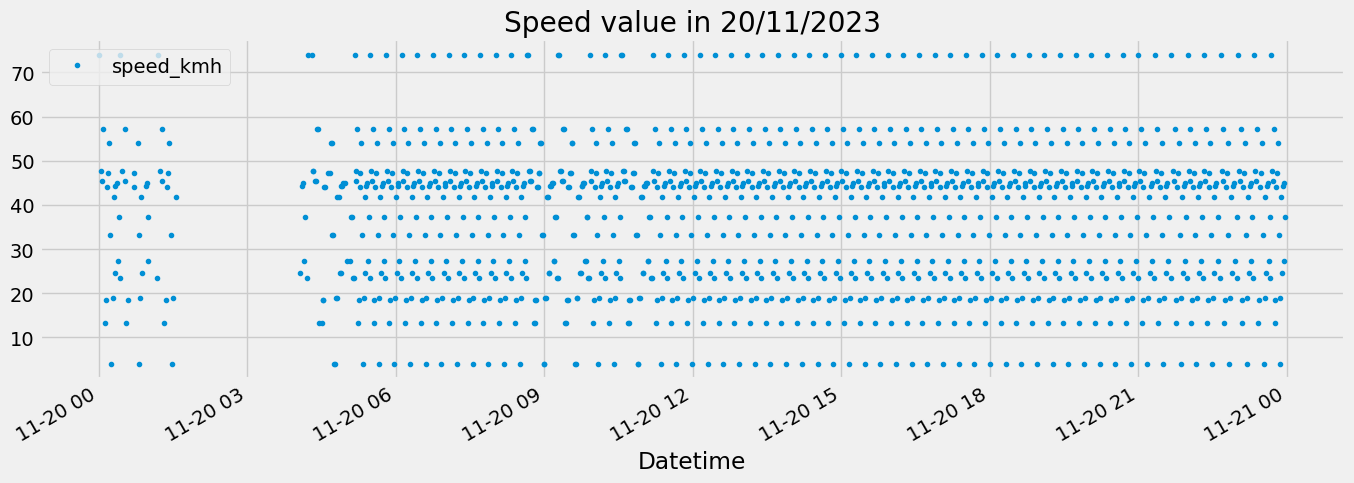

In [68]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Speed value in 20/11/2023')
plt.show()

<Axes: ylabel='Frequency'>

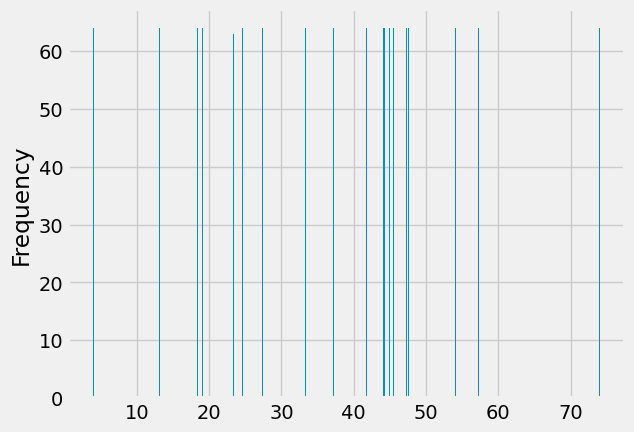

In [69]:
df['speed_kmh'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

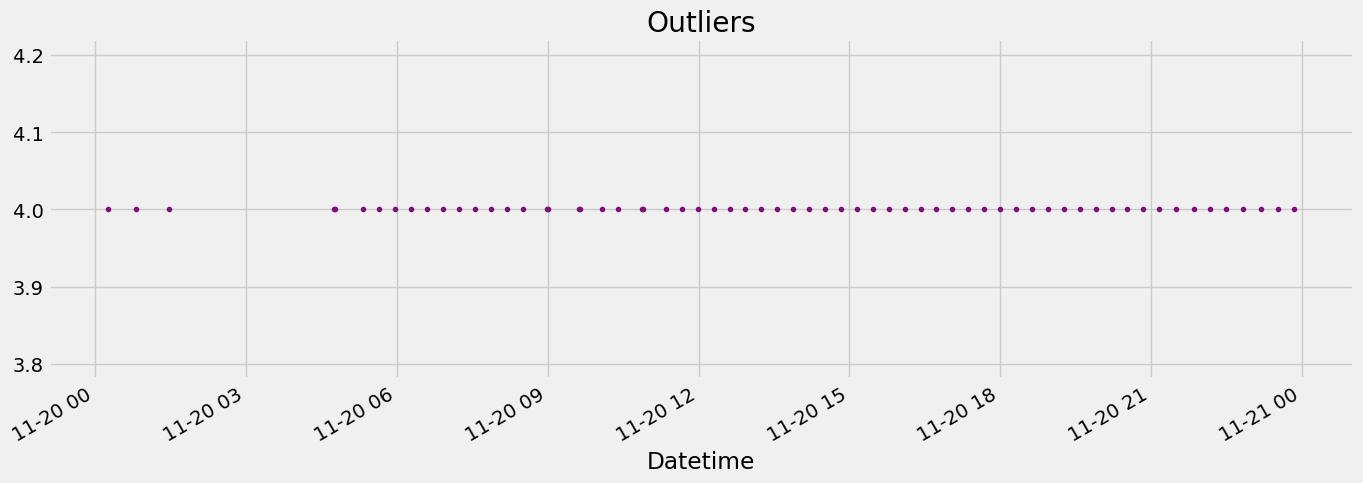

In [70]:
df.query('speed_kmh < 10')['speed_kmh'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

c:\Users\Administrator\miniconda3\lib\site-packages\matplotlib\axis.py:1732: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ret = self.converter.convert(x, self.units, self)


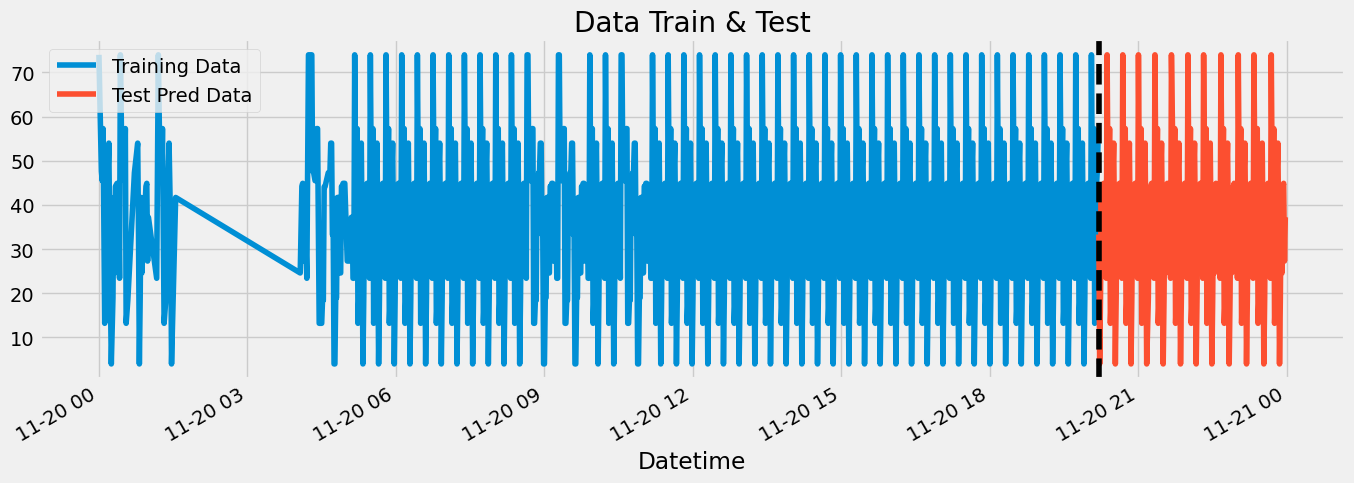

In [71]:
#Training / Testing Phase
train = df.loc[df.index < '11/20/2023  8:12:00 PM']
test = df.loc[df.index >= '11/20/2023  8:12:00 PM']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Data', title='Data Train & Test')
test.plot(ax=ax, label='Test Pred Data')
ax.axvline('11/20/2023  8:12:00 PM', color='black', ls='--')
ax.legend(['Training Data', 'Test Pred Data'])
plt.show()

In [75]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
tss = TimeSeriesSplit(n_splits=5, test_size=218, gap=5)
df = df.sort_index()

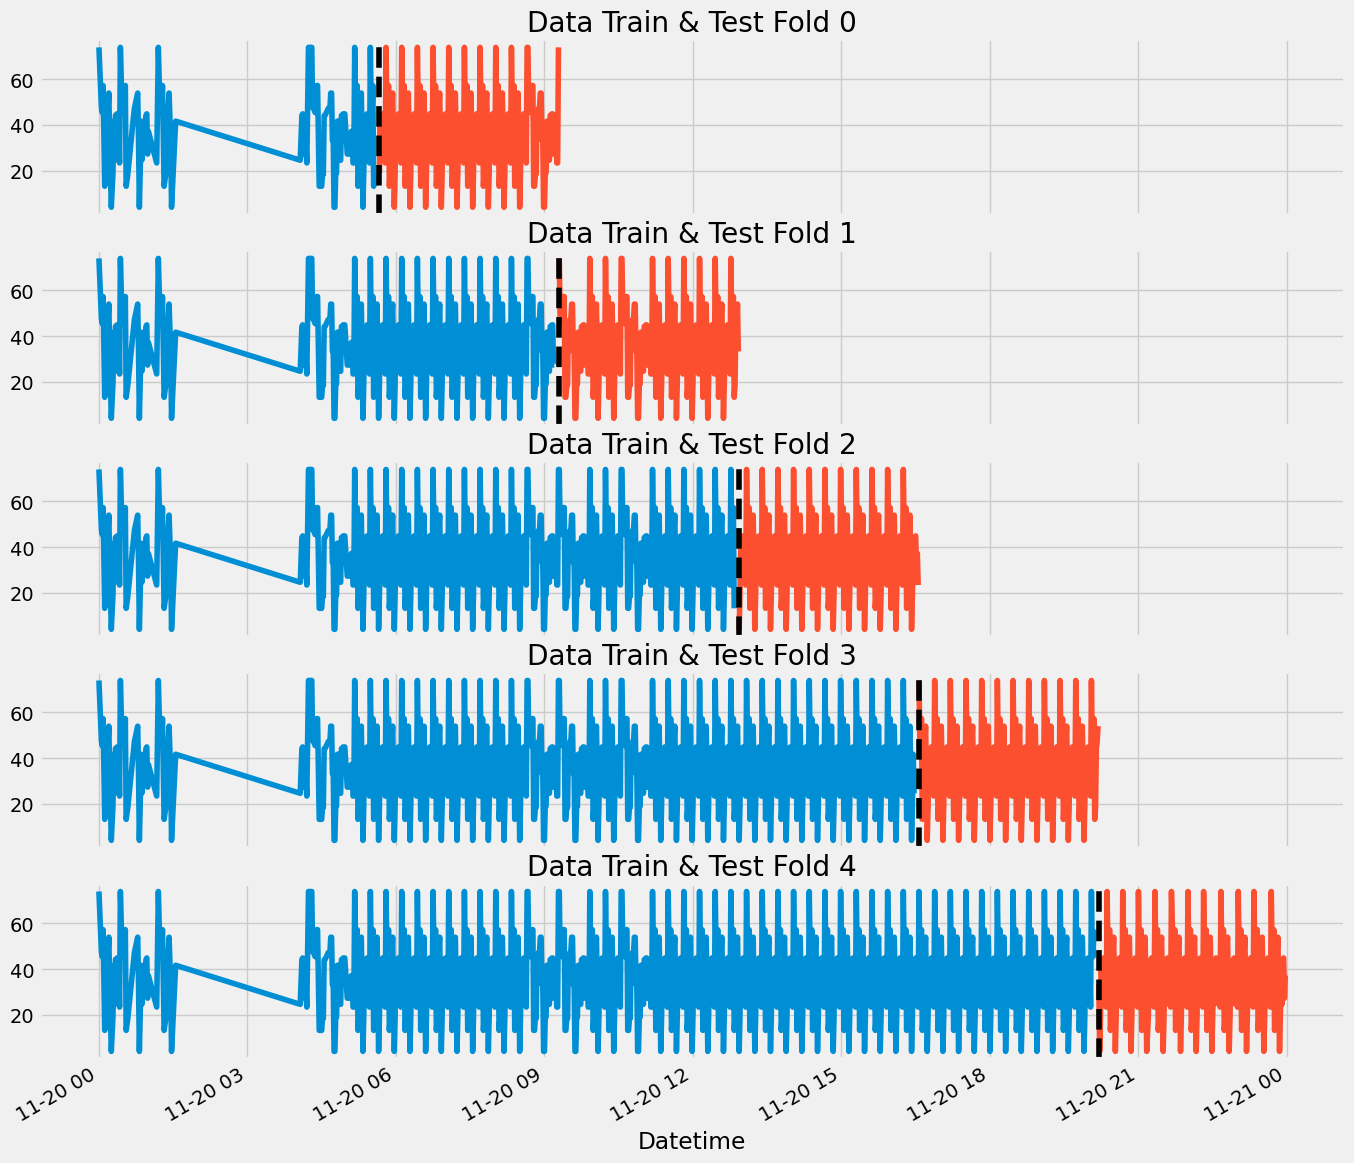

In [76]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['speed_kmh'].plot(ax=axs[fold],
                          label='Training Data',
                          title=f'Data Train & Test Fold {fold}')
    test['speed_kmh'].plot(ax=axs[fold],
                         label='Test PRed Data')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [77]:
#Forecasting Horizon Explained
#The forecast horizon is the length of time into the future for which forecasts are to be prepared.
#These generally vary from short-term forecasting horizons (less than three months)
#to long-term horizons (more than two years).

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [80]:
#Lag creature
def add_lags(df):
    target_map = df['speed_kmh'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('8 hours')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('16 hours')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('24 hours')).map(target_map)
    return df

In [81]:
df = add_lags(df)

In [84]:
##Train Using Cross Validation

tss = TimeSeriesSplit(n_splits=5, test_size=218, gap=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'speed_kmh'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:40.11275	validation_1-rmse:39.72929
[100]	validation_0-rmse:21.67103	validation_1-rmse:21.24500
[200]	validation_0-rmse:17.73153	validation_1-rmse:17.34000


c:\Users\Administrator\miniconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [00:31:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:17.12254	validation_1-rmse:16.81059
[400]	validation_0-rmse:17.03659	validation_1-rmse:16.72454
[500]	validation_0-rmse:17.02449	validation_1-rmse:16.70737
[600]	validation_0-rmse:17.02278	validation_1-rmse:16.70303
[700]	validation_0-rmse:17.02254	validation_1-rmse:16.70170
[800]	validation_0-rmse:17.02250	validation_1-rmse:16.70124
[900]	validation_0-rmse:17.02250	validation_1-rmse:16.70107
[999]	validation_0-rmse:17.02250	validation_1-rmse:16.70101
[0]	validation_0-rmse:39.82437	validation_1-rmse:39.81973
[100]	validation_0-rmse:21.21409	validation_1-rmse:22.24344
[200]	validation_0-rmse:17.08014	validation_1-rmse:18.49420


c:\Users\Administrator\miniconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [00:31:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:16.39065	validation_1-rmse:17.71626
[400]	validation_0-rmse:16.26554	validation_1-rmse:17.56010
[500]	validation_0-rmse:16.22907	validation_1-rmse:17.52462
[567]	validation_0-rmse:16.21663	validation_1-rmse:17.52634
[0]	validation_0-rmse:39.83842	validation_1-rmse:39.41946
[100]	validation_0-rmse:21.33897	validation_1-rmse:21.23962
[200]	validation_0-rmse:17.26302	validation_1-rmse:17.68604


c:\Users\Administrator\miniconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [00:31:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:16.59258	validation_1-rmse:17.54761
[301]	validation_0-rmse:16.59021	validation_1-rmse:17.55029
[0]	validation_0-rmse:39.74454	validation_1-rmse:40.04620
[100]	validation_0-rmse:20.58297	validation_1-rmse:20.75314
[200]	validation_0-rmse:16.03048	validation_1-rmse:16.24477


c:\Users\Administrator\miniconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [00:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:14.95832	validation_1-rmse:15.17254
[400]	validation_0-rmse:14.65154	validation_1-rmse:15.08615
[427]	validation_0-rmse:14.60099	validation_1-rmse:15.09702
[0]	validation_0-rmse:39.79995	validation_1-rmse:39.45286
[100]	validation_0-rmse:20.60057	validation_1-rmse:21.35814
[200]	validation_0-rmse:15.96181	validation_1-rmse:17.78766


c:\Users\Administrator\miniconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [00:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:15.08496	validation_1-rmse:17.38483
[327]	validation_0-rmse:14.99676	validation_1-rmse:17.45160


In [85]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 16.8337
Fold scores:[16.70100776223749, 17.52272137261264, 17.503493736299568, 15.077408935438905, 17.363812610095]


In [86]:
#Predicting the Future
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'speed_kmh'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:39.73206
[100]	validation_0-rmse:20.67984
[200]	validation_0-rmse:16.13464
[300]	validation_0-rmse:15.15002


c:\Users\Administrator\miniconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:14.83929
[499]	validation_0-rmse:14.68035


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [87]:
df.index.max()

Timestamp('2023-11-20 23:58:00')

In [93]:
future = pd.date_range('2023-11-21','2023-11-22', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [94]:
future_w_features = df_and_future.query('isFuture').copy()

In [95]:
#Predict the future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

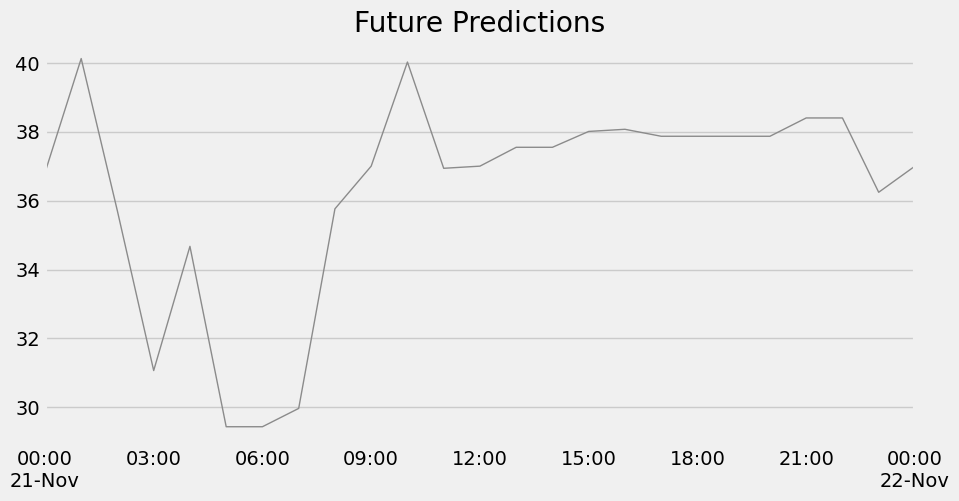

In [96]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()